####ALL IMPORTS

In [1]:
!pip install -q torchsummary 
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [2]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle
from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd ..
%cd gdrive

/
/gdrive


In [5]:
data_dir = 'MyDrive/AI_DATASET/Planet Dataset'
print(os.listdir(data_dir))

['train-jpg.tar', 'test-jpg.tar', 'test-jpg-additional.tar', 'test-jpg', 'train_v2.csv.zip', 'train_v2.csv', 'train-jpg']


In [7]:
path = "MyDrive/AI_DATASET/Planet Dataset/"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40679


In [8]:
path_class = os.path.join(path, "train_v2.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
df_class["list_tags"] = df_class.tags.str.split(" ")
classes = df_class.list_tags.values
tags = [tag for row in classes for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"Class": counter_tags.keys(), "Frequency": counter_tags.values()}
).sort_values("Frequency")

fig = px.bar(df_tags, x="Class", y="Frequency", orientation="v", 
             color="Frequency",color_continuous_scale=["red", "yellow",
                                         "green", "blue"]
)
fig.update_layout(title="Class distribution")
fig.show()

In [10]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

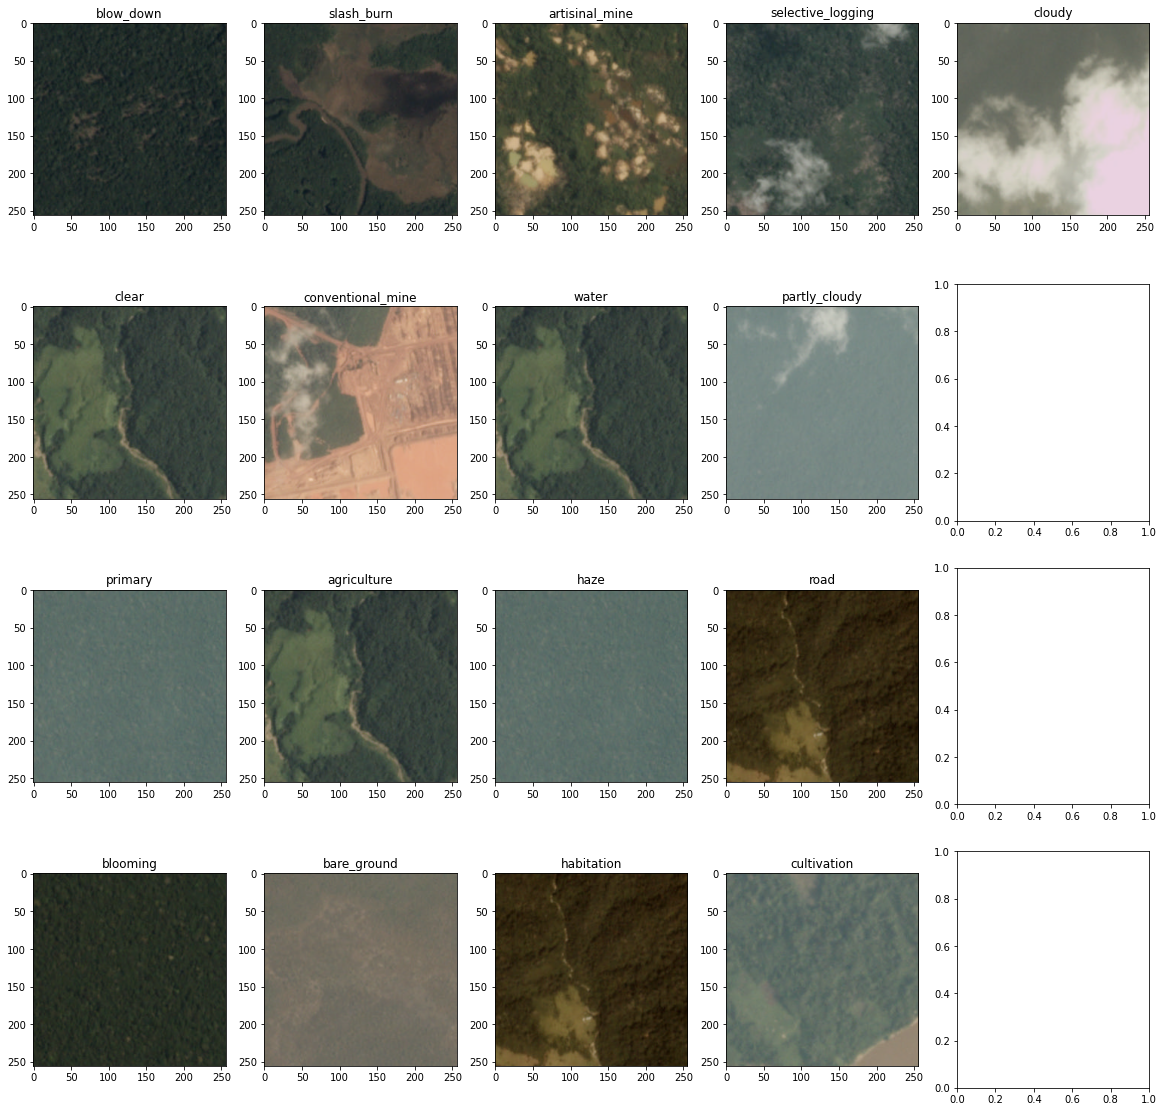

In [11]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)


In [12]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      ),
      T.RandomRotation((90,180)),
      T.RandomVerticalFlip(p=0.5),
      T.RandomHorizontalFlip(p=0.5)
        
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      ),
      T.RandomRotation((90,180)),
      T.RandomVerticalFlip(p=0.5),
      T.RandomHorizontalFlip(p=0.5)
    ])
    return transform_train, transform_val

In [13]:
class CustomDatasetError(Exception):
    pass


class CustomDataset(Dataset):
    def __init__(self, df, labels, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.labels = labels
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise CustomDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise CustomDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise CustomDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
#             img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, labels = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {labels}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
   

In [14]:
def get_data(df_train, df_val):
    encoder = MultiLabelBinarizer()
    tags_train = encoder.fit_transform(df_train.list_tags.values)
    tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = CustomDataset(df_train, tags_train, transform_train, path=path_train)
    ds_val = CustomDataset(df_val, tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=8,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=8,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [15]:
df_train, df_val = train_test_split(df_class, test_size=.2)


In [17]:
dl_train

NameError: ignored

In [79]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

# imgs, labels = next(iter(dl_train))
# imgs.shape, labels.shape

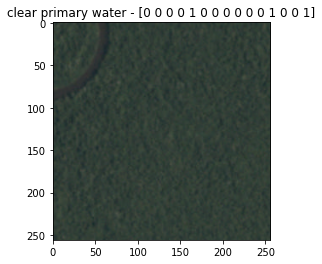

In [32]:
ds_train.load_img(1)

In [57]:

def get_model():
    model = models.resnet18(pretrained=False)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [80]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 4.5000% (9)
val bare_ground: 2.0000% (1)

train selective_logging: 1.5000% (3)
val selective_logging: 2.0000% (1)

train artisinal_mine: 2.0000% (4)
val artisinal_mine: 0.0000% (0)

train blooming: 1.5000% (3)
val blooming: 0.0000% (0)

train slash_burn: 0.5000% (1)
val slash_burn: 0.0000% (0)

train blow_down: 0.5000% (1)
val blow_down: 0.0000% (0)

train conventional_mine: 0.5000% (1)
val conventional_mine: 0.0000% (0)



In [77]:
len(dl_train)

24

In [23]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.cpu().detach().numpy()
    
    return Y_hat, batch_loss.item()


def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.cpu().detach().numpy()
    return Y_hat, batch_loss.item()

In [24]:
def class_acc(n_correct,n_samples,n_class_correct,n_class_samples):
    for i in range(17):
      print("-------------------------------------------------")
      acc = 100.0 * n_correct[i] / n_samples
      print(f'Overall class performance: {round(acc,1)} %')
      for k in range(17):
          acc = 100.0 * n_class_correct[i][k] / n_class_samples[i][k]
          print(f'Accuracy of class{i}/{k}: {round(acc,1)} %')
    print("-------------------------------------------------")

In [84]:
def calculate_average_accuracy(Y_train_epoch, Y_thresh_train_epoch):
      correctly_classified_samples=0
      total_number_of_samples=0
      for i in range(len(Y_train_epoch)):
          for k in range(17):
            LY=Y_train_epoch[i][k]
            PY=Y_thresh_train_epoch[i][k]

            if(LY==PY):
              correctly_classified_samples+=1

            total_number_of_samples+=1
    
      return float(100*(correctly_classified_samples/total_number_of_samples))
            



In [86]:
num_epochs = 10
total_steps = len(dl_train)
# t1 = time.time()
model,optimizer,loss_fn=get_model()
loss_train, loss_val = [], []
score_train, score_val = [], []
Y_hat_val = None
best_loss_val = np.inf
for epoch in range(num_epochs):

    loss_train_epoch, loss_val_epoch = [], []
    Y_hat_train_epoch, Y_hat_val_epoch = [], []
    Y_train_epoch, Y_val_epoch = [], []

    for j, data in enumerate(dl_train):
        
        images = data[0].to(device)
        outputs = model(images)
        labels =data[1].to(device)
        Y_hat, batch_loss=train_batch(images,labels,model,loss_fn,optimizer)
        loss_train_epoch.append(batch_loss)
        Y_hat_train_epoch.extend(Y_hat)
        Y_train_epoch.extend(labels.detach().float().cpu().numpy())

    for j, data in enumerate(dl_val):
        images = data[0].to(device)
        outputs = model(images)
        labels =data[1].to(device)
        Y_hat, batch_loss = compute_val_loss(images,labels,model,loss_fn,optimizer)
        loss_val_epoch.append(batch_loss)
        Y_hat_val_epoch.extend(Y_hat)
        Y_val_epoch.extend(labels.detach().float().cpu().numpy())




    avg_loss_train = np.mean(loss_train_epoch)
    avg_loss_val = np.mean(loss_val_epoch)
    Y_hat_train_epoch = np.array(Y_hat_train_epoch)
    Y_hat_val_epoch = np.array(Y_hat_val_epoch)
    Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
    Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
    Y_train_epoch = np.array(Y_train_epoch)
    Y_val_epoch = np.array(Y_val_epoch)

    score_train_epoch = calculate_average_accuracy(Y_train_epoch, Y_thresh_train_epoch)
    score_val_epoch = calculate_average_accuracy(Y_val_epoch, Y_thresh_val_epoch)

    # saving values for debugging
    if avg_loss_val < best_loss_val:
        best_loss_val = avg_loss_val
        Y_hat_val = Y_hat_val_epoch
        Y_thresh_val = Y_thresh_val_epoch
        Y_val = Y_val_epoch
            
    loss_train.append(avg_loss_train)
    loss_val.append(avg_loss_val)
    score_train.append(score_train_epoch)
    score_val.append(score_val_epoch)
    
    print(
            f"epoch: {epoch}/{num_epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
    )

train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }

torch.save(model, f"resnet.pth")
pickle.dump(train_results, open(f"train_results.pkl", "wb"))
    #     outputs = model(images)
    #     # print(outputs.data[0])
    #     Y_thresh_train_epoch = (Y_hat > .5).astype(float)
    #     labels=labels.cpu().detach().numpy()
    #     print(labels)
    #     print(Y_thresh_train_epoch)
    
    #     for i,out in enumerate(outputs):
    #       for k in range(17):
    #         LY=labels[i][k]
    #         PY=Y_thresh_train_epoch[i][k]

    #         if(LY==PY and k==0):
    #           class_0+=1
            
    #         if(k==0):
    #           class_0_samples+=1

    # print(100*class_0/class_0_samples)
        # for i,out in enumerate(outputs):
        #   print(i)
        #   print(out)
          
    #       _, predicted = torch.max(outputs.data,1)
    #       print(predicted)
    #       print(labels[i])
    #       n_correct[i] += (predicted == labels[i]).sum().item()
    #       if i == 0:
    #         n_samples += labels[i].size(0)

    #       for k in range(17):
    #         label = labels[i][k]
    #         pred = predicted[k]
    #         if (label == pred):
    #             n_class_correct[i][label] += 1
    #         n_class_samples[i][label] += 1
    
    # class_acc(n_correct,n_samples,n_class_correct,n_class_samples)
        # Train accuracy
        # total = labels.size(0)
        # _,predicted = torch.Sigmoid(outputs.data)
        # print(labels)
        # print(predicted)
        # correct = (predicted == labels).sum().item()
        # if (j + 1) % 100 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        #         .format(epoch + 1, num_epochs, j + 1, total_steps, loss.item(),
        #             (correct / total) * 100))
            
# print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

KeyboardInterrupt: ignored